# Setup

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = "\n".join(gpu_info)
# if gpu_info.find("failed") >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and the re-execute this cell')
# else:
#   print(gpu_info)

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
# !pip install fastai --upgrade

# Installing pytorch and torchvision with cuda support. Otherwise GPU won't work.
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import os
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import fastai
from fastai.vision.all import *
from PIL import Image
import shutil
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
import hashlib
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sn

In [5]:
# data_root = os.path.join("/content/drive/MyDrive/Ondato/data")
data_root = os.path.join(r"C:\Users\alessd\OneDrive - GPC\Desktop\VS_Code\data")
data_root

'C:\\Users\\alessd\\OneDrive - GPC\\Desktop\\VS_Code\\data'

# Loading data

In [6]:
data = []

for split in os.listdir(data_root):
    a = os.path.join(data_root, split)
    for label in os.listdir(a):
        a2 = os.path.join(data_root, split, label)
        for image in os.listdir(a2):
            data.append([image, split, label])


In [7]:
df = pd.DataFrame(data = data, columns = ["Image_id", "Split", "Label"])
df

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift
...,...,...,...
3995,zfaikp7qcdns1-IN.jpg,validation,wagonr
3996,zlukbdr2i2lk1-IN.jpg,validation,wagonr
3997,zvqtd7so1h392-IN.jpg,validation,wagonr
3998,zvybte2rc37k3-IN.jpg,validation,wagonr


## Moving all images in one directory

In [8]:
dst = r"C:\Users\alessd\OneDrive - GPC\Desktop\VS_Code\data_images"

for split in os.listdir(data_root):
    a = os.path.join(data_root, split)
    for label in os.listdir(a):
        a2 = os.path.join(data_root, split, label)
        for image in os.listdir(a2):
            src = os.path.join(a2, image)
            shutil.copy(src, dst)

In [9]:
data_root = r"C:\Users\alessd\OneDrive - GPC\Desktop\VS_Code"
data_root

'C:\\Users\\alessd\\OneDrive - GPC\\Desktop\\VS_Code'

In [10]:
len(list(os.listdir(os.path.join(data_root, "data_images"))))

4000

In [11]:
os.getcwd()

'C:\\Users\\alessd\\OneDrive - GPC\\Desktop\\VS_Code'

# EDA

## Checking nulls, splits and Labels vizualization

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  4000 non-null   object
 1   Split     4000 non-null   object
 2   Label     4000 non-null   object
dtypes: object(3)
memory usage: 93.9+ KB


In [13]:
df.describe()

,Image_id,Split,Label
count,4000,4000,4000
unique,4000,3,2
top,03hnkjxhh2w83-IN.jpg,train,swift
freq,1,2400,2000


In [14]:
df.isnull().sum()

Image_id    0
Split       0
Label       0
dtype: int64

<AxesSubplot:>

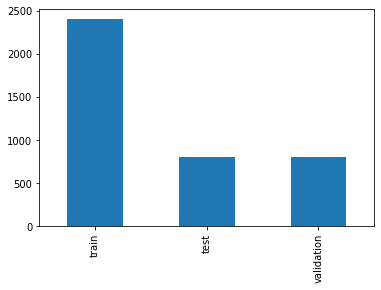

In [15]:
df["Split"].value_counts().plot.bar()

<AxesSubplot:>

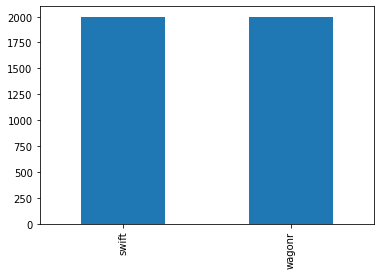

In [16]:
df["Label"].value_counts().plot.bar()

<AxesSubplot:>

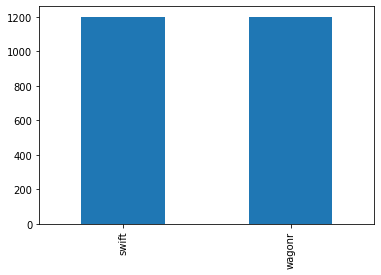

In [17]:
df[df["Split"] == "train"]["Label"].value_counts().plot.bar()

<AxesSubplot:>

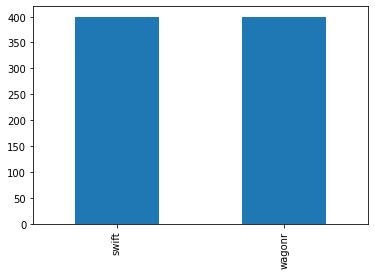

In [18]:
df[df["Split"] == "validation"]["Label"].value_counts().plot.bar()

<AxesSubplot:>

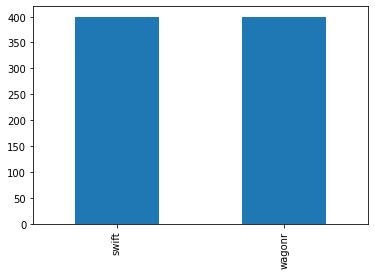

In [19]:
df[df["Split"] == "test"]["Label"].value_counts().plot.bar()

In [20]:
len(df)

4000

## Checking for visually similar images with different uuids

Image hashing or perceptual hashing is the process of: Examining the contents of an image. Constructing a hash value that uniquely identifies an input image based on the contents of an image

In [21]:
photos = list(os.listdir(os.path.join(data_root, "data_images")))
len(photos)

4000

In [22]:
# pairs of duplicate photos indexes will be saved here
duplicates_md5 = []

# all hash keys will be saved here
hash_keys = dict()

for index, filename in enumerate(photos):

  # getting hash key
  filehash = hashlib.md5(Image.open(os.path.join(data_root, "data_images", filename)).tobytes()).hexdigest()

  # storing all unique hash keys
  if filehash not in hash_keys:
    hash_keys[filehash] = index

  # storing indexes of duplicates
  else:
    duplicates_md5.append((index, hash_keys[filehash]))

In [23]:
duplicates_md5[:10]

[(124, 108),
 (399, 87),
 (515, 420),
 (588, 583),
 (596, 437),
 (607, 126),
 (668, 277),
 (706, 4),
 (735, 385),
 (769, 287)]

Visualizing duplicated images and checking if they are really duplicated

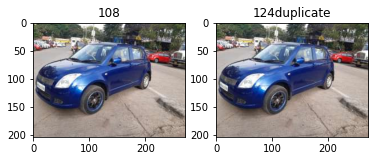

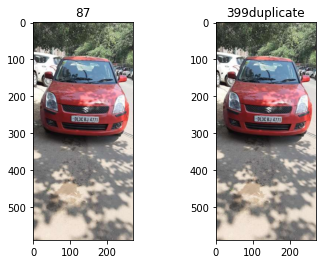

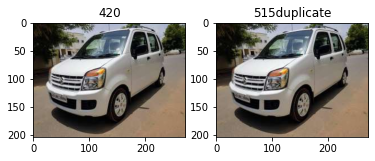

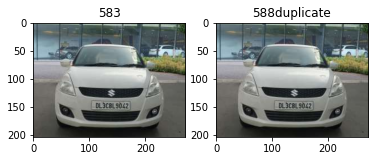

In [24]:
for file_indexes in duplicates_md5[:4]:
  plt.subplot(121)
  plt.imshow(Image.open(os.path.join(data_root, "data_images", photos[file_indexes[1]])))
  plt.title(file_indexes[1])


  plt.subplot(122)
  plt.imshow(Image.open(os.path.join(data_root, "data_images", photos[file_indexes[0]])))
  plt.title(str(file_indexes[0]) + "duplicate")


  plt.show()

Creating lists for original and duplicate photos filenames

In [25]:
original_fns = []
duplicates_fns = []

for duplicate, original in duplicates_md5:
  duplicates_fns.append(photos[duplicate])
  original_fns.append(photos[original])

In [26]:
original_fns[0]

'0y4sseaydwwk-IN.jpg'

In [27]:
df = df[~df["Image_id"].isin(original_fns)]
df

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift
...,...,...,...
3995,zfaikp7qcdns1-IN.jpg,validation,wagonr
3996,zlukbdr2i2lk1-IN.jpg,validation,wagonr
3997,zvqtd7so1h392-IN.jpg,validation,wagonr
3998,zvybte2rc37k3-IN.jpg,validation,wagonr


In [28]:
df.reset_index().drop(columns = ["index"], inplace = True)
df

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift
...,...,...,...
3995,zfaikp7qcdns1-IN.jpg,validation,wagonr
3996,zlukbdr2i2lk1-IN.jpg,validation,wagonr
3997,zvqtd7so1h392-IN.jpg,validation,wagonr
3998,zvybte2rc37k3-IN.jpg,validation,wagonr


In [29]:
os.getcwd()

'C:\\Users\\alessd\\OneDrive - GPC\\Desktop\\VS_Code'

# Saving / Loading final df

In [30]:
# df.to_csv("/content/drive/MyDrive/Ondato/df.csv", index = False)
df.to_csv("df.csv", index = False)

In [2]:
data_root = r"C:\Users\alessd\OneDrive - GPC\Desktop\VS_Code"
# df = pd.read_csv("/content/drive/MyDrive/Ondato/df.csv")
df = pd.read_csv(r"df.csv")
df

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift
...,...,...,...
3821,zfaikp7qcdns1-IN.jpg,validation,wagonr
3822,zlukbdr2i2lk1-IN.jpg,validation,wagonr
3823,zvqtd7so1h392-IN.jpg,validation,wagonr
3824,zvybte2rc37k3-IN.jpg,validation,wagonr


# Splits

## Test dataset

In [31]:
test_df = df[df["Split"] == "test"]
test_df

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift
...,...,...,...
795,zmvnl40khr8v3-IN.jpg,test,wagonr
796,zntklti84pdp1-IN.jpg,test,wagonr
797,zpi2suv0j8go3-IN.jpg,test,wagonr
798,zugt1ms564fw2-IN.jpg,test,wagonr


## Train_val dataset

In [32]:
trainval_df = df[df["Split"] != "test"]
trainval_df

,Image_id,Split,Label
800,00duslv28ydk2-IN.jpg,train,swift
801,00xwm26884k-IN.jpg,train,swift
802,034zbve1rf6x1-IN.jpg,train,swift
803,03m2c8qw9ys73-IN.jpg,train,swift
804,050zxklfw5br1-IN.jpg,train,swift
...,...,...,...
3995,zfaikp7qcdns1-IN.jpg,validation,wagonr
3996,zlukbdr2i2lk1-IN.jpg,validation,wagonr
3997,zvqtd7so1h392-IN.jpg,validation,wagonr
3998,zvybte2rc37k3-IN.jpg,validation,wagonr


In [33]:
trainval_df = trainval_df.copy()
trainval_df["is_valid"] = [True if i == "validation" else False for i in trainval_df["Split"]]
trainval_df

,Image_id,Split,Label,is_valid
800,00duslv28ydk2-IN.jpg,train,swift,False
801,00xwm26884k-IN.jpg,train,swift,False
802,034zbve1rf6x1-IN.jpg,train,swift,False
803,03m2c8qw9ys73-IN.jpg,train,swift,False
804,050zxklfw5br1-IN.jpg,train,swift,False
...,...,...,...,...
3995,zfaikp7qcdns1-IN.jpg,validation,wagonr,True
3996,zlukbdr2i2lk1-IN.jpg,validation,wagonr,True
3997,zvqtd7so1h392-IN.jpg,validation,wagonr,True
3998,zvybte2rc37k3-IN.jpg,validation,wagonr,True


In [34]:
trainval_df.shape

(3060, 4)

In [35]:
trainval_df["is_valid"].value_counts()

False    2299
True      761
Name: is_valid, dtype: int64

In [36]:
os.getcwd()

'C:\\Users\\alessd\\OneDrive - GPC\\Desktop\\VS_Code'

# Modelling

- aug_transforms is a function that provides a collection of data augmentation transforms with defaults founded that perform well on many datasets.
- augmentations are applied to train dataset only



## Augmentation, resize

In [37]:
path = os.path.join(data_root, "data_images")
dls = ImageDataLoaders.from_df(trainval_df,  
                               path,
                               seed=42,
                               label_col=2,
                               item_tfms=Resize(460), 
                               batch_tfms=aug_transforms(size=224),
                               valid_col="is_valid")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\alessd\AppData\Roaming\Python\Python38\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [38]:
print("Number of batches in train dataloader: ", len(dls[0]))
print("Number of batches in test dataloader: ", len(dls[1]))

Number of batches in train dataloader:  35
Number of batches in test dataloader:  12


Checking of categories contains all categories

In [39]:
print(dls[0].vocab)
print(dls[1].vocab)

['swift', 'wagonr']
['swift', 'wagonr']


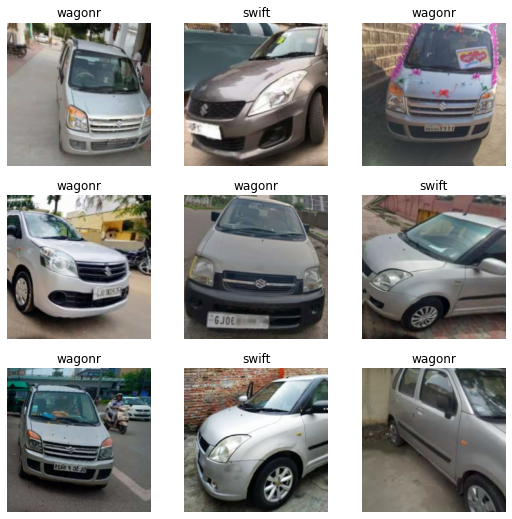

In [40]:
dls.show_batch()

## Resnet34 pretrained

Note: if normalize and pretrained are True, normalize function adds a Normalization transform to the dls (if there is not already one) using the statistics of the pretrained model

In [41]:
learn = cnn_learner(dls,
                    arch = resnet34,
                    pretrained = True,
                    cbs = ShowGraphCallback,
                    metrics = [accuracy],
                    normalize = True,
                    )

C:\Users\alessd\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Finding the right learning rate

C:\Users\alessd\.conda\envs\Bloga_dokumentacija_bert\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0010000000474974513)

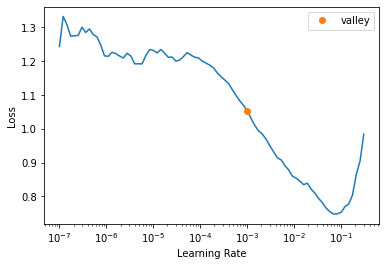

In [42]:
learn.lr_find()

Method fine_tune means "freezes" all the other layers except the last meaning that optimizer will update only the last layers. After freezing the model it’s common to do just one epoch to update the parameters in the last layer.

epoch,train_loss,valid_loss,accuracy,time
0,0.239463,0.121400,0.957950,00:22


Better model found at epoch 0 with valid_loss value: 0.12139981985092163.


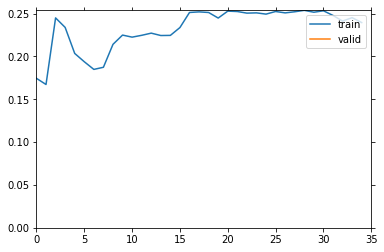

epoch,train_loss,valid_loss,accuracy,time
0,0.208198,0.078871,0.965834,00:30
1,0.163012,0.066919,0.968463,00:29
2,0.122500,0.051926,0.973719,00:28
3,0.097502,0.036634,0.984231,00:28
4,0.079958,0.045704,0.977661,00:30
5,0.074817,0.043188,0.986859,00:28
6,0.058850,0.021051,0.986859,00:28
7,0.050512,0.033411,0.986859,00:27
8,0.044723,0.014214,0.992116,00:30
9,0.037486,0.015657,0.992116,00:26


Better model found at epoch 0 with valid_loss value: 0.07887063175439835.


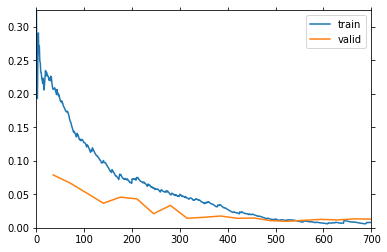

Better model found at epoch 1 with valid_loss value: 0.06691931188106537.
Better model found at epoch 2 with valid_loss value: 0.05192556977272034.
Better model found at epoch 3 with valid_loss value: 0.036633893847465515.
Better model found at epoch 6 with valid_loss value: 0.021050868555903435.
Better model found at epoch 8 with valid_loss value: 0.014213882386684418.
Better model found at epoch 11 with valid_loss value: 0.014160511083900928.
Better model found at epoch 13 with valid_loss value: 0.010609696619212627.
Better model found at epoch 14 with valid_loss value: 0.009720581583678722.


In [45]:
learn.fine_tune(20, base_lr=0.001, cbs=SaveModelCallback(monitor = "valid_loss", fname = "resnet34_pretrained", every_epoch = False))

## Results on validation dataset

Let's look at some items
- actual labels - top
- predicted labels - bottom

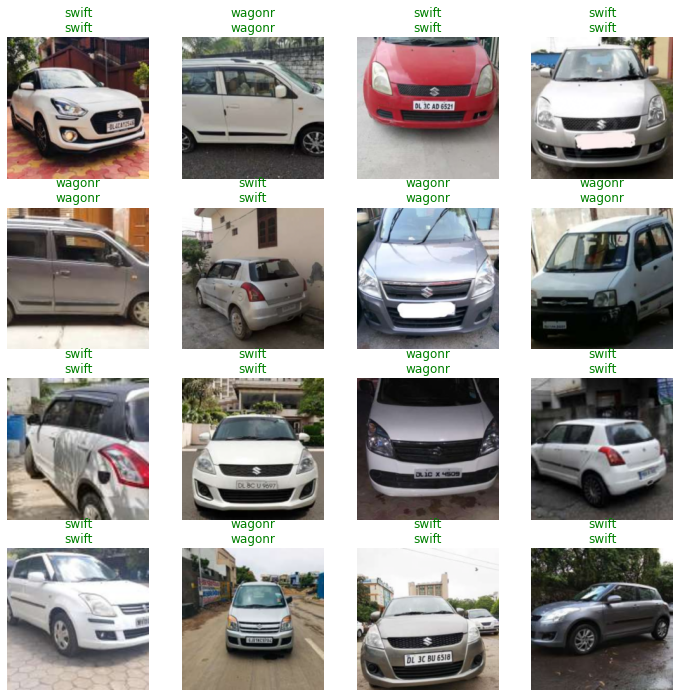

In [46]:
learn.show_results(max_n=16)

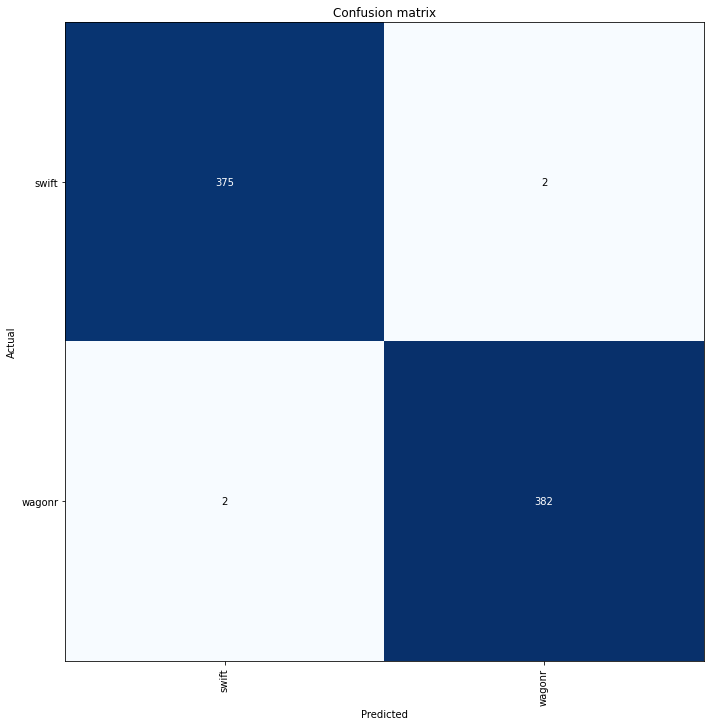

In [47]:
interp_classification = ClassificationInterpretation.from_learner(learn)
interp_classification.plot_confusion_matrix(figsize =(10,10))

Classification report shows the same information as confusion matrix but just in numbers

In [48]:
interp_classification.print_classification_report()

              precision    recall  f1-score   support

       swift       0.99      0.99      0.99       377
      wagonr       0.99      0.99      0.99       384

    accuracy                           0.99       761
   macro avg       0.99      0.99      0.99       761
weighted avg       0.99      0.99      0.99       761



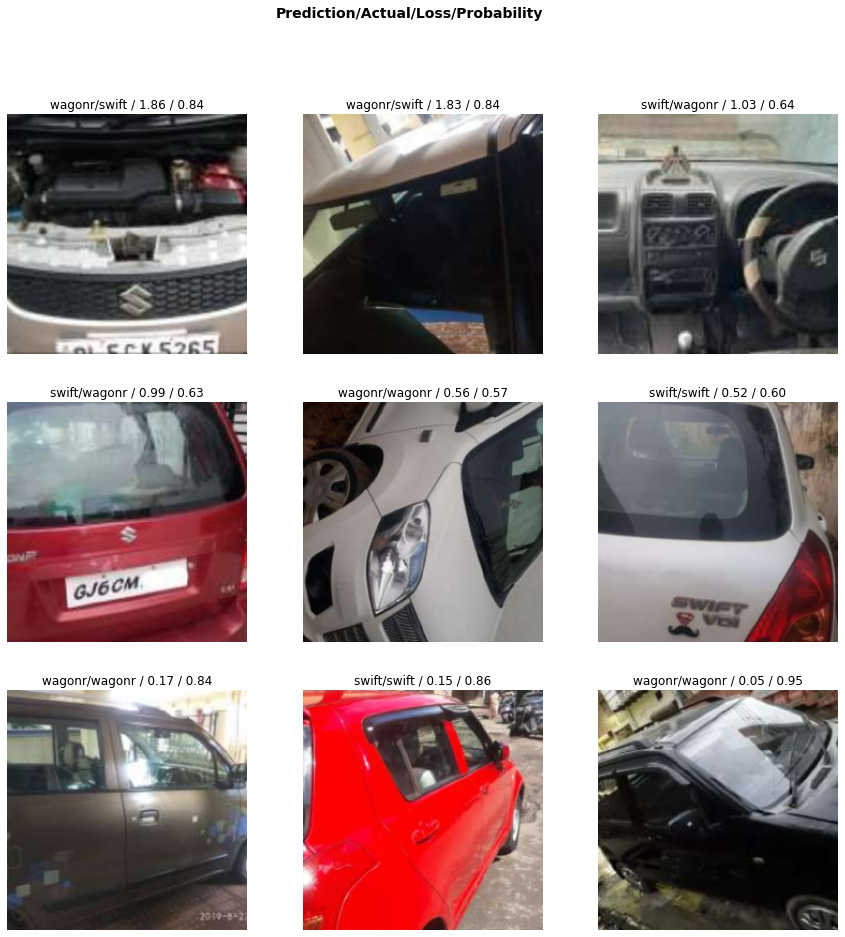

In [49]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15,15))

# Results on test dataset

As you can see with Fastai you can easy show wanted metrics for train-val datasets. But we still need to evaluate test dataset. So lets define a function to get these metrics from test dataset

In [50]:
test_df.head()

,Image_id,Split,Label
0,03hnkjxhh2w83-IN.jpg,test,swift
1,03jxnlgy0jof3-IN.jpg,test,swift
2,07wx78v7q2xq-IN.jpg,test,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift
4,0d2vshwzpl47-IN.jpg,test,swift


In [51]:
def test_dataframe(
                   df: pd.core.frame.DataFrame, 
                   learn: fastai.learner.Learner, 
                   photos_path: str,
                   column: str) -> list:
    
    predicted_categories = []
    probs = []

    for filename in df[column]:
        result = learn.predict(os.path.join(photos_path, filename))
        category = result[0]
        prob = np.array(result[2])
        predicted_categories.append(category)
        probs.append(prob)
        
    probs = np.array(probs)
    return predicted_categories, probs

In [52]:
results = test_dataframe(test_df, learn, os.path.join(data_root, "data_images"), column = "Image_id")

In [53]:
test_df = test_df.copy()
test_df["pred"] = results[0]
test_df.head()

,Image_id,Split,Label,pred
0,03hnkjxhh2w83-IN.jpg,test,swift,swift
1,03jxnlgy0jof3-IN.jpg,test,swift,swift
2,07wx78v7q2xq-IN.jpg,test,swift,swift
3,0aa2pr4uspgv1-IN.jpg,test,swift,swift
4,0d2vshwzpl47-IN.jpg,test,swift,swift


Same results as on validation dataset

In [54]:
print(classification_report(test_df["Label"], test_df["pred"], zero_division=1))

              precision    recall  f1-score   support

       swift       0.99      0.99      0.99       379
      wagonr       0.99      0.99      0.99       387

    accuracy                           0.99       766
   macro avg       0.99      0.99      0.99       766
weighted avg       0.99      0.99      0.99       766



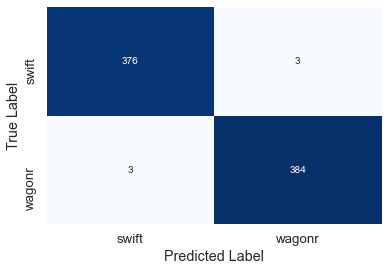

In [57]:
array = confusion_matrix(test_df["Label"], test_df["pred"])
df_cm = pd.DataFrame(array, range(2), range(2))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d", cbar=False, cmap="Blues", xticklabels=["swift", "wagonr"], yticklabels=["swift", "wagonr"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Exporting model

In [59]:
os.chdir(r"C:\Users\alessd\OneDrive - GPC\Desktop\VS_Code")

In [61]:
learn.export("model.pkl")